# **Bias Mitigation with Plugin Estimator and Calibrator**
This tutorial demonstrates how to implement the "Plugin Estimator and Calibrator" postprocessing method to enhance fairness in regression models using the `holisticai` library.

- [Traditional implementation](#traditional-implementation)
- [Pipeline implementation](#pipeline-implementation)

First, install the `holisticai` package if you haven't already:
```bash
!pip install holisticai[all]
```
Then, import the necessary libraries.

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from holisticai.datasets import load_dataset
from holisticai.bias.mitigation import PluginEstimationAndCalibration
from holisticai.bias.metrics import regression_bias_metrics

np.random.seed(0)
import warnings
warnings.filterwarnings("ignore")

Load the proprocessed "Communities and Crime" dataset.

In [3]:
dataset = load_dataset('us_crime', protected_attribute="race")

dataset

In [4]:
dataset['y'].shape

(1993,)

Now that we have a clean dataset we can start defining the protected groups and the training and testing sets.

## **3. Data analysis**

Since this function already return the protected groups, we can start with the data analysis step. In this step, we will analyze the distribution of the data of the protected groups by using the `group_pie_plot` function. This function will plot the distribution of the data of the protected groups in a pie chart.

<Axes: >

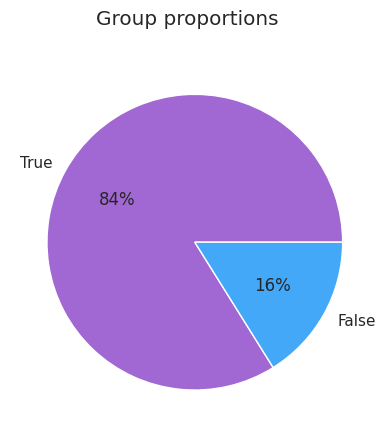

In [5]:
from holisticai.bias.plots import group_pie_plot

group_pie_plot(dataset['group_a'])

This graph show us that the proportion of white people (labelled as *True*) is very high compared to the remain races.

Let's plot the columns with the highest correlations with respect to the target variable. To do this, we will use the `correlation_matrix_plot` function. 

<Axes: title={'center': 'Correlation matrix'}>

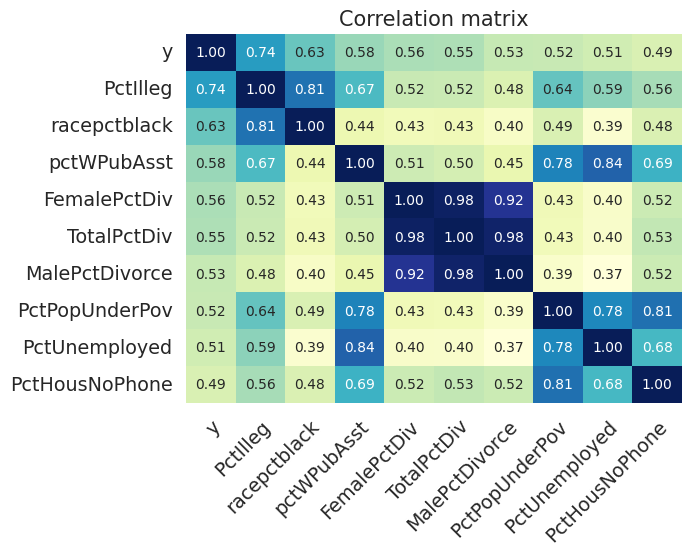

In [6]:
from holisticai.datasets.plots import correlation_matrix_plot

correlation_matrix_plot(dataset, features=['X'], target_feature="y", n_features=10)

To obtain properly values with the mitigator, we will scale the objective column:

In [7]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

scaler = StandardScaler()
y = scaler.fit_transform(dataset['y'].values.reshape(-1, 1))
y = np.squeeze(y)

# Convert the numpy array to a pandas Series
dataset['y_norm'] = pd.Series(y)

# Concatenate the series to the dataset
#dataset = dataset.map(lambda x: {'y_norm': y_series})

dataset = dataset.train_test_split(test_size=0.2, random_state=0)

train_data = dataset['train']
test_data = dataset['test']

In [8]:
model = LinearRegression()

model.fit(train_data['X'], train_data['y_norm'])
y_pred = model.predict(test_data['X'])

df = regression_bias_metrics(
    test_data['group_a'],
    test_data['group_b'],
    y_pred,
    test_data['y_norm'],
    metric_type='both'
)
df

,Value,Reference
Metric,,
Disparate Impact Q90,0.019666,1
Disparate Impact Q80,0.117994,1
Disparate Impact Q50,0.412979,1
Statistical Parity Q50,-0.705605,0
No Disparate Impact Level,-0.777897,-
Average Score Difference,-1.604353,0
Average Score Ratio,-0.235742,1
Z Score Difference,-2.750267,0
Max Statistical Parity,0.767257,0


## **Bias Mitigation**
### **Traditional Implementation**
We will implement the "Plugin estimator and calibrator" method, an post-processing technique to mitigate bias in the regression model.

In [9]:
model = LinearRegression()

model.fit(train_data['X'], train_data['y_norm'])
y_pred = model.predict(train_data['X'])

post_processer = PluginEstimationAndCalibration()
post_processer.fit_transform(y_pred, train_data['group_a'], train_data['group_b'])
post_processer

In [10]:
y_pred = model.predict(test_data['X'])

y_pred = post_processer.transform(y_pred, test_data['group_a'], test_data['group_b'])['y_pred']

df = regression_bias_metrics(
    test_data['group_a'],
    test_data['group_b'],
    y_pred,
    test_data['y_norm'],
    metric_type='both'
)
df

,Value,Reference
Metric,,
Disparate Impact Q90,0.427729,1
Disparate Impact Q80,0.766962,1
Disparate Impact Q50,1.000000,1
Statistical Parity Q50,-0.058260,0
No Disparate Impact Level,0.375000,-
Average Score Difference,-0.034691,0
Average Score Ratio,0.846290,1
Z Score Difference,-0.108646,0
Max Statistical Parity,0.239676,0


In [11]:
pec_rmse = mean_squared_error(test_data['y_norm'], y_pred, squared=False)
print("RMS error: {}".format(pec_rmse))

RMS error: 0.9225356257728464


### **Pipeline Implementation**
Implementing the method using the pipeline.

In [12]:
from holisticai.pipeline import Pipeline

model = LinearRegression()
pipeline = Pipeline(
    steps=[
        ("model", model),
        ("bm_postprocessing", PluginEstimationAndCalibration()),
    ]
)

fit_params = {
    "bm__group_a": train_data['group_a'], 
    "bm__group_b": train_data['group_b']
}

pipeline.fit(train_data['X'], train_data['y_norm'], **fit_params)
pipeline

Pipeline(steps=[('model',
                 <holisticai.pipeline.handlers._estimator.WEstimator object at 0x7ff774bfa910>)])

In [13]:

predict_params = {
    "bm__group_a": test_data['group_a'],
    "bm__group_b": test_data['group_b'],
}
y_pred_pipeline = pipeline.predict(test_data['X'], **predict_params)
df_pipeline = regression_bias_metrics(
    test_data['group_a'],
    test_data['group_b'],
    y_pred,
    test_data['y_norm'],
    metric_type='both'
)
df_pipeline

,Value,Reference
Metric,,
Disparate Impact Q90,0.427729,1
Disparate Impact Q80,0.766962,1
Disparate Impact Q50,1.000000,1
Statistical Parity Q50,-0.058260,0
No Disparate Impact Level,0.375000,-
Average Score Difference,-0.034691,0
Average Score Ratio,0.846290,1
Z Score Difference,-0.108646,0
Max Statistical Parity,0.239676,0


In [14]:
pipeline_rmse = mean_squared_error(test_data['y_norm'], y_pred_pipeline, squared=False)
print("Pipeline RMSE: {}".format(pipeline_rmse))

Pipeline RMSE: 0.9225356257728464
